In [23]:
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(1)

print("Mevcut kullanılabilir GPU adedi : ", len(tf.config.list_physical_devices('GPU')))

Mevcut kullanılabilir GPU adedi :  1


In [24]:
from keras.datasets import fashion_mnist

# Fashion MNIST datasetini yukle

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()




In [25]:
import numpy as np


#merge the training and testing sets
dataset = np.concatenate([x_train, x_test], axis=0)
print(dataset.shape)
#normalize the images
dataset= np.expand_dims(dataset,-1).astype("float32")/255
print(dataset.shape)

(70000, 28, 28)
(70000, 28, 28, 1)


In [26]:
BATCH_SIZE = 64


dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(1024).batch(BATCH_SIZE)
dataset


<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [27]:
from keras import layers

NOISE_DIM = 100

generator = keras.models.Sequential(
    [
        layers.InputLayer(input_shape=(NOISE_DIM,)),
        layers.Dense(7 * 7 * 256), #12544
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding="same",activation="LeakyReLU"),
        layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same",activation="LeakyReLU"),
        layers.Conv2DTranspose(1, kernel_size=3, padding="same",activation="sigmoid")

    ]
)

generator.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1266944   
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 256)      590080    
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        1153      
 ranspose)                                                       
                                                      

In [28]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, kernel_size=5, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=5, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=5, strides=1, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 256)         819456    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 256)         0         
                                                                 
 flatten_1 (Flatten)         (None, 12544)           

In [29]:
optimizerG = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizerD = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

gAccMetric = keras.metrics.BinaryAccuracy()
dAccMetric = keras.metrics.BinaryAccuracy()

In [30]:
@tf.function
def trainDstep(data):
    batchSize = tf.shape(data)[0]
    noise = tf.random.normal([batchSize, NOISE_DIM])

    y_true = tf.concat([tf.ones((batchSize, 1)), tf.zeros((batchSize, 1))], axis=0)

    with tf.GradientTape() as tape:
        fake = generator(noise)
        x = tf.concat([data, fake], axis=0)
        y_pred = discriminator(x)
        discriminatorLoss = loss_fn(y_true, y_pred)
    
    grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
    optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))

    dAccMetric.update_state(y_true, y_pred)

    return {
        "discriminator_loss": discriminatorLoss,
        "discriminator_accuracy": dAccMetric.result()
    }

In [31]:
@tf.function
def trainGstep(data):
    batchSize = tf.shape(data)[0]
    noise = tf.random.normal([batchSize, NOISE_DIM])

    y_true = tf.ones((batchSize, 1))

    with tf.GradientTape() as tape:
        fake = generator(noise)
        y_pred = discriminator(fake)
        generatorLoss = loss_fn(y_true, y_pred)
    
    grads = tape.gradient(generatorLoss, generator.trainable_weights)
    optimizerG.apply_gradients(zip(grads, generator.trainable_weights))

    gAccMetric.update_state(y_true, y_pred)

    return {
        "generator_loss": generatorLoss,
        "generator_accuracy": gAccMetric.result()
    }



In [32]:
from matplotlib import pyplot as plt

def plotImages(model):
    images = model(np.random.normal(size=(25, NOISE_DIM)))

    plt.figure(figsize=(5, 5))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i, :, :, 0], cmap="gray")
        plt.axis("off")

    plt.show()

    


E:0, Loss G:1.0704013109207153, Loss D:0.4961428642272949, Acc G:0.05615714192390442, Acc D:0.7293285727500916


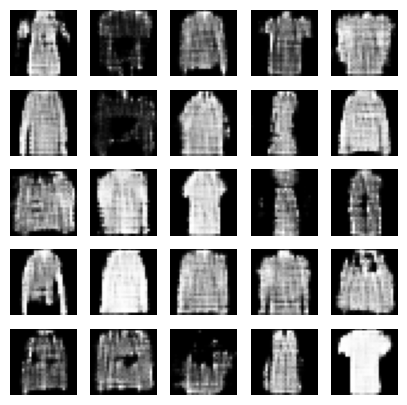

In [33]:
for epoch in range(50):
    dLossSum = 0
    gLossSum = 0
    dAccSum = 0
    gAccSum = 0
    cnt = 0


    for batch in dataset:

        dResult= trainDstep(batch)
        gResult = trainGstep(batch)
        
        # dLossSum += dLoss["discriminator_loss"]
        # gLossSum += gLoss["generator_loss"]
        # dAccSum += dLoss["discriminator_accuracy"]
        # gAccSum += gLoss["generator_accuracy"]
        cnt += 1

    # print("E:{}, Loss G:{}, Loss D:{}, Acc G:{}, Acc D:{}".format(epoch, gLossSum/cnt, dLossSum/cnt, 100*gAccSum/cnt, 100*dAccSum/cnt))
    print("E:{}, Loss G:{}, Loss D:{}, Acc G:{}, Acc D:{}".format(epoch, gResult["generator_loss"], dResult["discriminator_loss"], gResult["generator_accuracy"], dResult["discriminator_accuracy"]))
    
    plotImages(generator)
        
        